# Marine Heatwave Classification 

***
Author: Hillary Scannell: https://github.com/hscannell

This notebook reads in data from a netCDF file containing daily sea surface tempeatures (SSTs) in the North Pacific. Marine heatwaves are defined as SST that exceeds the 90th percentile using a fixed 30-year climatology. Daily data is smoothed with a 31-day filter and the percentile is calculated using a pooled average centered in an 11-day sliding window. 

#### Metrics are computed at each grid point:
* 90th percentile threshold climatology --> climatologoy_threshold
* seasonal 30-year climatology -->  seasonal_climatology
* Marine heatwave anomaly above the seasonal climatology  --> mhw_anomaly
* Marine heatwave duration index on day 1 of event --> mhw_duration
* Average marine heatwave duration --> avg_duration
* Average marine heatwave intensity --> avg_intensity
* Average number of events per year (frequency) --> mhw_freq

_This code was adapted from Eric Oliver's [marineHeatWaves](https://github.com/ecjoliver/marineHeatWaves) module that was based on Hobday et al. [2016]_

## Step #1: Data Acquisition

***

To download the Optimum Interpolation Sea Surface Temperature (OISST) dataset, run the shell script [webgetOISST.txt](https://github.com/cse512-18s/marine-heatwave/blob/master/data/webgetOISSTnetCDF.txt). This script will download netCDF files from NOAA and create a new directory for files on your machine. _[warning: this data is about 18 GB total]_
* **New Directory**: ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2.highres/

Data from year between 1981-present will be a seperate netCDF file. Step 2 describes how to concatenate these files along the time dimension and subsection files to extract data only from the North Pacific.


## Step #2. Data Concatenation

***

After all the OISST netCDF files are download, go to the directory where the files are stored on your machine and run the shell script [concatOISST.txt](https://github.com/cse512-18s/marine-heatwave/blob/master/data/concatOISST.txt) from the terminal. This script with stack the files from 1981-2018 along the time dimension and create a new file called _OISSTv2.1981.2018.nc_. It then extracts data from _OISSTv2.1981.2018.nc_ between 20-65ºN and 125ºE-105ºW. This will produce a new file called _OISSTv2.NP.1981.2018.nc_ with daily SST data from 1981 to 2018 in the North Pacific. 

## Step #3. Import Python Libraries

***

In [12]:
get_ipython().magic('matplotlib inline')
import numpy as np
import numpy.ma as ma
import os
import matplotlib.pyplot as plt
import scipy as sp
import datetime 
from datetime import date
import time 
import pandas as pd
import netCDF4
from netCDF4 import Dataset
import sys
import cartopy.crs as ccrs
import scipy.ndimage as ndimage
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import scipy.ndimage as ndimage

## Step #4. Set Parameters and Define Functions

***

In [13]:
# Call your local directory where OISSTv2.NP.1981.2018.nc is stored
fp = "/Users/Scannell/Desktop/marine-heatwave/data/ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2.highres/OISSTv2.NP.1981.2018.nc" 

# Where to store calculated marine heatwave metrics
path = "/Users/Scannell/Desktop/marine-heatwave/data/" 

# Boolean switch indicating whether to smooth the threshold percentile timeseries with a moving average
smoothPercentile=True

# Width of moving average window for smoothing threshold
smoothPercentileWidth=31 

#Period over which climatology is calculated, specified as list of start and end years
climatologyPeriod=[1988,2017] 

# Threshold percentile (%) for detection of extreme values
pctile=90

# Width of window (one sided) about day-of-year used for the pooling of values and calculation of threshold percentile
windowHalfWidth=5 




def nonans(array):
    '''
    Return input array [1D numpy array] with
    all nan values removed
    '''
    return array[~np.isnan(array)]


def nans(shape, dtype=float):
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a


def runavg(ts, w):
    '''
    Performs a running average of an input time series using uniform window
    of width w. This function assumes that the input time series is periodic.
    Inputs:
      ts            Time series [1D numpy array]
      w             Integer length (must be odd) of running average window
    Outputs:
      ts_smooth     Smoothed time series
    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Feb-Mar 2015
    '''
    # Original length of ts
    N = len(ts)
    # make ts three-fold periodic
    ts = np.append(ts, np.append(ts, ts))
    # smooth by convolution with a window of equal weights
    ts_smooth = np.convolve(ts, np.ones(w)/w, mode='same')
    # Only output central section, of length equal to the original length of ts
    ts = ts_smooth[N:2*N]

    return ts

## Step #5. Load Data & Variable Information 

***

In [24]:
file2read = Dataset(fp) # reading the nc file and creating a dataset
for i in file2read.variables:
    print(file2read[i].name, file2read[i].dimensions, file2read[i].size)

t = file2read.variables['time'][:] # time is given in days since 1800-01-01 00:00:00
ref = datetime.date(1800,1,1).toordinal() 
time = ref + t
sst = file2read.variables['sst'][:]
lon = file2read.variables['lon'][:]
lat = file2read.variables['lat'][:]

lat ('lat',) 180
lon ('lon',) 520
sst ('time', 'lat', 'lon') 1255644000
time ('time',) 13415


## Step #6. Preview Data

***

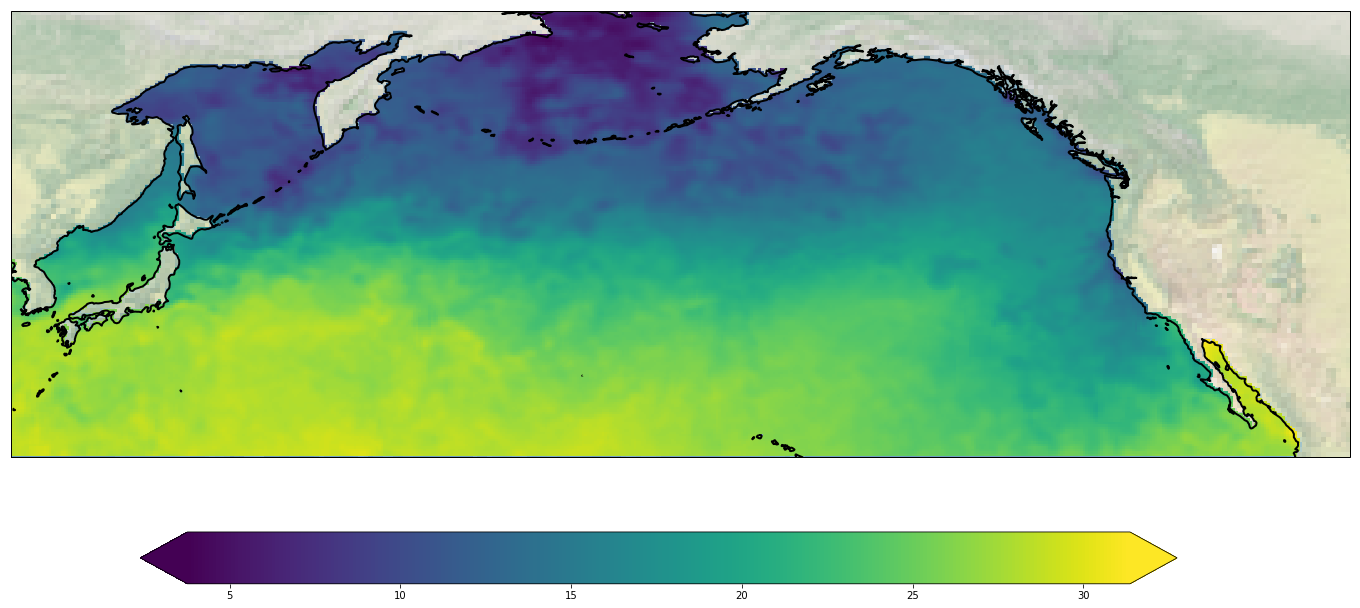

In [11]:
# Make quick checkpoint figure of SST
f=plt.figure(figsize=(24, 24))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([125,260,20,65], ccrs.PlateCarree())
ax.stock_img()
im = ax.pcolormesh(lon-180, lat, sst[0,:,:]); #plt.show(block=False)
ax.coastlines(resolution='50m', color='black', linewidth=2)
colorbar_ax = f.add_axes([0.2, 0.3, 0.6, 0.03])
_=plt.colorbar(im,cax=colorbar_ax,orientation='horizontal',extend='both')

## Step #7. Convert time from proleptic Gregorian ordinal to a calendar dates _(year, month and day)_ and day of year

Takes in to account leap years.

***


In [ ]:
T = len(time)
year = np.zeros((T))
month = np.zeros((T))
day = np.zeros((T))
doy = np.zeros((T))

for i in range(len(time)):
    year[i] = date.fromordinal(int(time[i])).year
    month[i] = date.fromordinal(int(time[i])).month
    day[i] = date.fromordinal(int(time[i])).day

# Leap-year baseline for defining day-of-year values
year_leapYear = 2012 # This year was a leap-year and therefore doy in range of 1 to 366
t_leapYear = np.arange(date(year_leapYear, 1, 1).toordinal(),date(year_leapYear, 12, 31).toordinal()+1)
dates_leapYear = [date.fromordinal(tt.astype(int)) for tt in t_leapYear]
month_leapYear = np.zeros((len(t_leapYear)))
day_leapYear = np.zeros((len(t_leapYear)))
doy_leapYear = np.zeros((len(t_leapYear)))
for tt in range(len(t_leapYear)):
    month_leapYear[tt] = date.fromordinal(t_leapYear[tt]).month
    day_leapYear[tt] = date.fromordinal(t_leapYear[tt]).day
    doy_leapYear[tt] = t_leapYear[tt] - date(date.fromordinal(t_leapYear[tt]).year,1,1).toordinal() + 1

# Calculate day-of-year values
for tt in range(T):
    doy[tt] = doy_leapYear[(month_leapYear == month[tt]) * (day_leapYear == day[tt])]

# Constants (doy values for Feb-28 and Feb-29) for handling leap-years
feb28 = 59
feb29 = 60

## Step #8. Loop through data to compute marine heatwave metrics

Returns (variable_name, size) :
* seasonal_climatology [13415,180,520]
* climatologoy_threshold [13415,180,520]
* mhw_anomaly [13415,180,520]
* mhw_duration [13415,180,520]
* avg_duration [180,520]
* avg_intensity [180,520]
* mhw_freq [180,520]

***

In [ ]:
# Initialize matrices 
MHW_start_index =  nans([13415,180,520])
seasonal_climatology = nans([13415,180,520])
climatologoy_threshold = nans([13415,180,520])
mhw_anomaly = nans([13415,180,520])
mhw_duration = nans([13415,180,520])
mhw_freq = nans([1,180,520])
avg_intensity = nans([1,180,520])
avg_duration = nans([1,180,520])

# Loop through each lat-lon pair and calculate MHW metrics
for i in range(len(lat)):
    print((i+1)/180*100,'% complete')
    for j in range(len(lon)):
        
        ssti = np.ma.filled(sst[:,i,j], np.nan)
        if np.isnan(ssti).any(): 
                continue # continues with the next iteration of the loop
                
        tempClim = ssti.copy()
        TClim = np.array([T]).copy()[0]
        yearClim = year.copy()
        monthClim = month.copy()
        dayClim = day.copy()
        doyClim = doy.copy()
        
        # Length of climatological year
        lenClimYear = 366

        # Start and end indices
        clim_start = np.where(yearClim == climatologyPeriod[0])[0][0]
        clim_end = np.where(yearClim == climatologyPeriod[1])[0][-1]

        # Inialize arrays
        thresh_climYear = np.NaN*np.zeros(lenClimYear)
        seas_climYear = np.NaN*np.zeros(lenClimYear)
        clim = {}
        clim['thresh'] = np.NaN*np.zeros(TClim)
        clim['seas'] = np.NaN*np.zeros(TClim)

        # Loop over all day-of-year values, and calculate threshold and seasonal climatology across years
        for d in range(1,lenClimYear+1):
            # Special case for Feb 29
            if d == feb29:
                continue
            # find all indices for each day of the year +/- windowHalfWidth and from them calculate the threshold
            tt0 = np.where(doyClim[clim_start:clim_end+1] == d)[0] 
            # If this doy value does not exist (i.e. in 360-day calendars) then skip it
            if len(tt0) == 0:
                continue
            tt = np.array([])
            for w in range(-windowHalfWidth, windowHalfWidth+1):
                tt = np.append(tt, clim_start+tt0 + w)
            tt = tt[tt>=0] # Reject indices "before" the first element
            tt = tt[tt<TClim] # Reject indices "after" the last element
            thresh_climYear[d-1] = np.percentile(nonans(tempClim[tt.astype(int)]), pctile)
            seas_climYear[d-1] = np.mean(nonans(tempClim[tt.astype(int)]))

        # Special case for Feb 29
        thresh_climYear[feb29-1] = 0.5*thresh_climYear[feb29-2] + 0.5*thresh_climYear[feb29]
        seas_climYear[feb29-1] = 0.5*seas_climYear[feb29-2] + 0.5*seas_climYear[feb29]
        
        if smoothPercentile:
            # If the climatology contains NaNs, then assume it is a <365-day year and deal accordingly
            if np.sum(np.isnan(seas_climYear)) + np.sum(np.isnan(thresh_climYear)): # does data contain any nans
                valid = ~np.isnan(thresh_climYear)
                thresh_climYear[valid] = runavg(thresh_climYear[valid], smoothPercentileWidth)
                valid = ~np.isnan(seas_climYear)
                seas_climYear[valid] = runavg(seas_climYear[valid], smoothPercentileWidth)
            # >= 365-day year
            else:
                thresh_climYear = runavg(thresh_climYear, smoothPercentileWidth)
                seas_climYear = runavg(seas_climYear, smoothPercentileWidth)

        # Generate threshold for full time series
        clim['thresh'] = thresh_climYear[doy.astype(int)-1]
        clim['seas'] = seas_climYear[doy.astype(int)-1]

        # Save vector indicating which points in temp are missing values
        clim['missing'] = np.isnan(ssti)
        # Set all remaining missing sst values equal to the climatology
        ssti[np.isnan(ssti)] = clim['seas'][np.isnan(ssti)]

        # Time series of "True" when threshold is exceeded, "False" otherwise
        exceed_bool = ssti - clim['thresh']
        exceed_bool[exceed_bool<=0] = False # normal SST
        exceed_bool[exceed_bool>0] = True # MHW

        # Find contiguous regions of exceed_bool = True
        events, n_events = ndimage.label(exceed_bool) # Label features in an array. non-zero values in input are counted as features and zero values are considered the background.
            # events = An integer ndarray where each unique feature in input has a unique label in the returned array.
            # n_events = Number of objects found.
            
        # Initialize MHW output variable
        mhw = {}
        mhw['time_start'] = [] # datetime format
        mhw['time_end'] = [] # datetime format

        minDuration=5
        for ev in range(1,n_events+1):
            event_duration = (events == ev).sum()
            if event_duration < minDuration:
                continue # continues with the next iteration of the loop
            mhw['time_start'].append(time[np.where(events == ev)[0][0]])
            mhw['time_end'].append(time[np.where(events == ev)[0][-1]])

        # Link heat waves that occur before and after a short gap (gap must be no longer than maxGap)
        joinAcrossGaps= True
        maxGap=2
        if joinAcrossGaps:
            # Calculate gap length for each consecutive pair of events
            gaps = np.array(mhw['time_start'][1:]) - np.array(mhw['time_end'][0:-1]) - 1
            if len(gaps) > 0:
                while gaps.min() <= maxGap:
                    # Find first short gap
                    ev = np.where(gaps <= maxGap)[0][0]
                    # Extend first MHW to encompass second MHW (including gap)
                    mhw['time_end'][ev] = mhw['time_end'][ev+1]
                    # Remove second event from record
                    del mhw['time_start'][ev+1]
                    del mhw['time_end'][ev+1]
                    # Calculate gap length for each consecutive pair of events
                    gaps = np.array(mhw['time_start'][1:]) - np.array(mhw['time_end'][0:-1]) - 1
                    if len(gaps) == 0:
                        break
                        
        # Initialize MHW output variable
        mhw['time_peak'] = [] # datetime format
        mhw['date_start'] = [] # datetime format
        mhw['date_end'] = [] # datetime format
        mhw['date_peak'] = [] # datetime format
        mhw['index_start'] = []
        mhw['index_end'] = []
        mhw['index_peak'] = []
        mhw['duration'] = [] # [days]

        # Calculate marine heat wave properties
        mhw['n_events'] = len(mhw['time_start'])
        for ev in range(mhw['n_events']):
            mhw['date_start'].append(date.fromordinal(int(mhw['time_start'][ev])))
            mhw['date_end'].append(date.fromordinal(int(mhw['time_end'][ev])))
        # Get SST series during MHW event, relative to both threshold and to seasonal climatology
            tt_start = np.where(time==mhw['time_start'][ev])[0][0]
            tt_end = np.where(time==mhw['time_end'][ev])[0][0]
            mhw['index_start'].append(tt_start)
            mhw['index_end'].append(tt_end)
            temp_mhw = ssti[tt_start:tt_end+1]
            thresh_mhw = clim['thresh'][tt_start:tt_end+1]
            seas_mhw = clim['seas'][tt_start:tt_end+1]
            mhw_relSeas = temp_mhw - seas_mhw
            mhw_relThresh = temp_mhw - thresh_mhw
            mhw_relThreshNorm = (temp_mhw - thresh_mhw) / (thresh_mhw - seas_mhw)
            mhw_abs = temp_mhw
        # Find peak
            tt_peak = np.argmax(mhw_relSeas) # index of maiximum value
            mhw['time_peak'].append(mhw['time_start'][ev] + tt_peak)
            mhw['date_peak'].append(date.fromordinal(int(mhw['time_start'][ev]) + tt_peak)) # adding index of peak to start time
            mhw['index_peak'].append(tt_start + tt_peak)
        # MHW Duration
            mhw['duration'].append(len(mhw_relSeas))
        # MHW Anomaly above seasonal climatology    
            mhw_anomaly[(np.arange(tt_start,tt_end+1)),i,j] = mhw_relSeas # MHW tempeature anomaly
        
        # Store data for each lat-lon combination
        seasonal_climatology[:,i,j] = np.asarray(clim['seas'])
        climatologoy_threshold[:,i,j] = np.asarray(clim['thresh'])
        mhw_anomaly[(np.arange(tt_start,tt_end+1)),i,j] = mhw_relSeas # MHW tempeature anomaly
        mhw_duration[mhw['index_start'],i,j] = np.asarray(mhw['duration']) # event duration index on day 1
        avg_duration[0,i,j] = np.asarray(mhw['duration']).mean() # average duration
        avg_intensity[0,i,j] = mhw_relSeas.mean() # average intensity
        mhw_freq[0,i,j] = np.asarray(mhw['n_events'])/37 # average no. of events per year (averaged over 37 years)

ssta = sst - seasonal_climatology

## Step #9. Save New Variables (mhw_stats_NP.npz)

***mhw_stats_NP.npz***
* ssta[13415,180,520]
* seasonal_climatology [13415,180,520]
* climatologoy_threshold [13415,180,520]
* mhw_anomaly [13415,180,520]
* mhw_duration [13415,180,520]
* avg_duration [180,520]
* avg_intensity [180,520]
* mhw_freq [180,520]

***

In [ ]:
# Save Output in directory specified as "path" in Step #4 
os.chdir(path)
print ('where this data will be saved: ',os.getcwd())

np.savez('mhw_stats_NP', seasonal_climatology=seasonal_climatology, climatologoy_threshold=climatologoy_threshold,mhw_anomaly=mhw_anomaly,mhw_duration=mhw_duration,avg_duration=avg_duration,avg_intensity=avg_intensity,mhw_freq=mhw_freq,ssta=ssta)


In [15]:
## To reload saved data without re-running previous cells, uncomment the code below and re-run Step #3 (Python libraries) and Step #5 (SST data)

# data = np.load('mhw_stats_NP.npz')
# print(data.keys())
# seasonal_climatology = data["seasonal_climatology"]
# climatologoy_threshold = data['climatologoy_threshold']
# avg_intensity = data['avg_intensity']
# avg_duration = data['avg_duration']
# mhw_freq = data['mhw_freq']
# ssta = data['ssta'] 

['seasonal_climatology', 'climatologoy_threshold', 'mhw_anomaly', 'mhw_duration', 'avg_duration', 'avg_intensity', 'mhw_freq']


## Step #10. Plot 1981-2018 Mean Marine Heatwave Duration

Saves as _meanMHWduration.png_ in current working directory

***

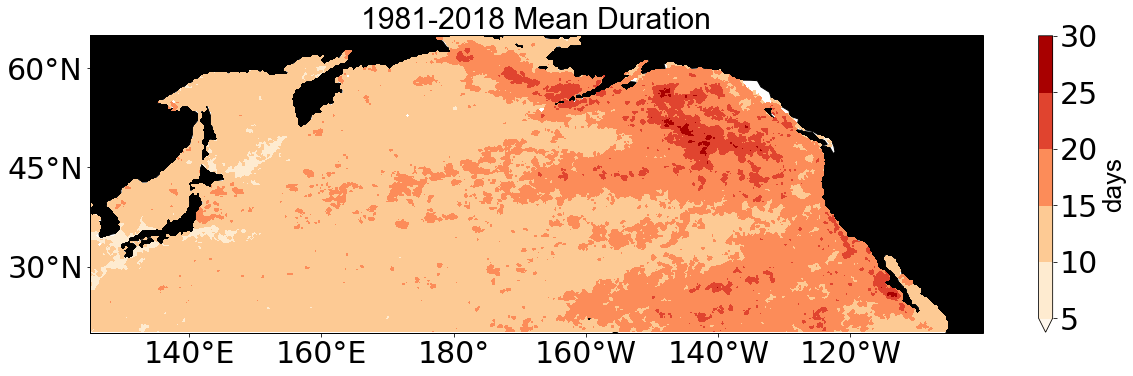

In [20]:
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
fig = plt.figure(figsize=(20, 20)) # 8,10

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_global()
ax1.set_extent([-55, 80, 20, 65], crs=ccrs.PlateCarree(central_longitude=180))
ax1.set_xticks([140,160,180,200,220,240], crs=ccrs.PlateCarree())
ax1.set_yticks([30,45,60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
levels = [5,10,15,20,25,30]
CS = plt.contourf(lon-180, lat, np.squeeze(avg_duration), levels, cmap=plt.cm.OrRd,extend ='min')
cbar = plt.colorbar(CS, shrink=0.6, extend ='both')
ax1.add_feature(cfeature.LAND,facecolor='k')
ttl = plt.title('1981-2018 Mean Duration',fontname='Arial',fontsize=30,loc='center')
cbar.ax.set_ylabel('days',fontname='Arial',fontsize=26)

fig.savefig('meanMHWduration.png',bbox_inches='tight')

## Step #11. Plot 1981-2018 Mean Marine Heatwave Frequency

Saves as _meanMHWfrequency.png_ in current working directory

***

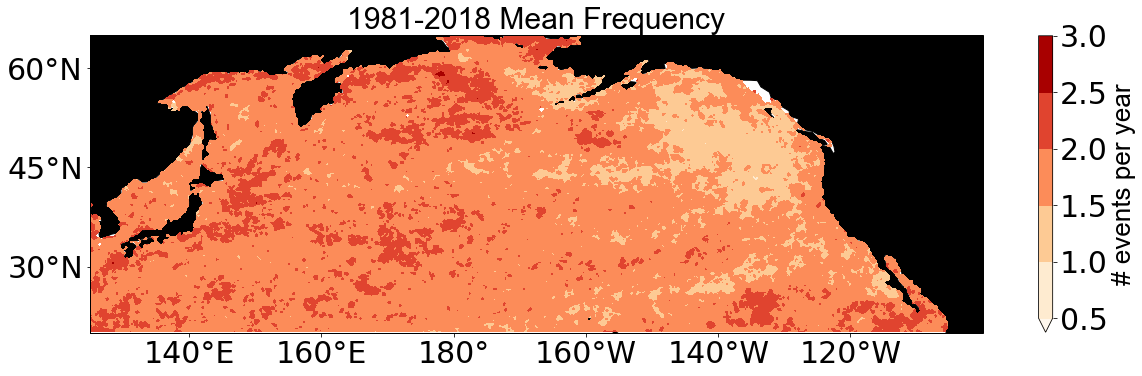

In [21]:
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
fig = plt.figure(figsize=(20, 20)) # 8,10

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_global()
ax1.set_extent([-55, 80, 20, 65], crs=ccrs.PlateCarree(central_longitude=180))
ax1.set_xticks([140,160,180,200,220,240], crs=ccrs.PlateCarree())
ax1.set_yticks([30,45,60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
levels = [0.5,1,1.5,2,2.5,3]
CS = plt.contourf(lon-180, lat, np.squeeze(mhw_freq), levels, cmap=plt.cm.OrRd,extend ='min')
cbar = plt.colorbar(CS, shrink=0.6)
ax1.add_feature(cfeature.LAND,facecolor='k')
ttl = plt.title('1981-2018 Mean Frequency',fontname='Arial',fontsize=30,loc='center')
cbar.ax.set_ylabel('# events per year',fontname='Arial',fontsize=26)

fig.savefig('meanMHWfrequency.png',bbox_inches='tight')

## Step #12. Plot 1981-2018 Mean Marine Heatwave Intensity

Saves as _meanMHWintensity.png_ in current working directory

***

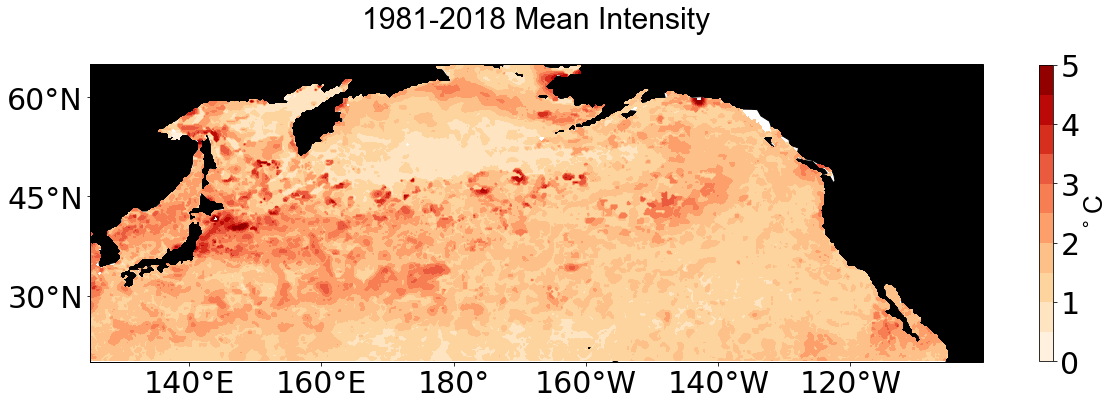

In [22]:
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
fig = plt.figure(figsize=(20, 20)) # 8,10

# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_global()
ax1.set_extent([-55, 80, 20, 65], crs=ccrs.PlateCarree(central_longitude=180))
ax1.set_xticks([140,160,180,200,220,240], crs=ccrs.PlateCarree())
ax1.set_yticks([30,45,60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
levels = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
CS = plt.contourf(lon-180, lat, np.squeeze(avg_intensity), levels, cmap=plt.cm.OrRd)
cbar = plt.colorbar(CS, shrink=0.6, extend ='both')
ax1.add_feature(cfeature.LAND,facecolor='k')
ttl = plt.title('1981-2018 Mean Intensity',fontname='Arial',fontsize=30,loc='center')
ttl.set_position([.5, 1.10])
cbar.ax.set_ylabel('$^\circ$C',fontname='Arial',fontsize=26)

fig.savefig('meanMHWintensity.png',bbox_inches='tight')

## Step #13. Plot Marine Heatwave Classification Figure 

Saves as _definingMHW.png_ in current working directory

***


(array([104]),) (array([364]),)
latitude 46.125 ºN and longitude 143.875 ºW


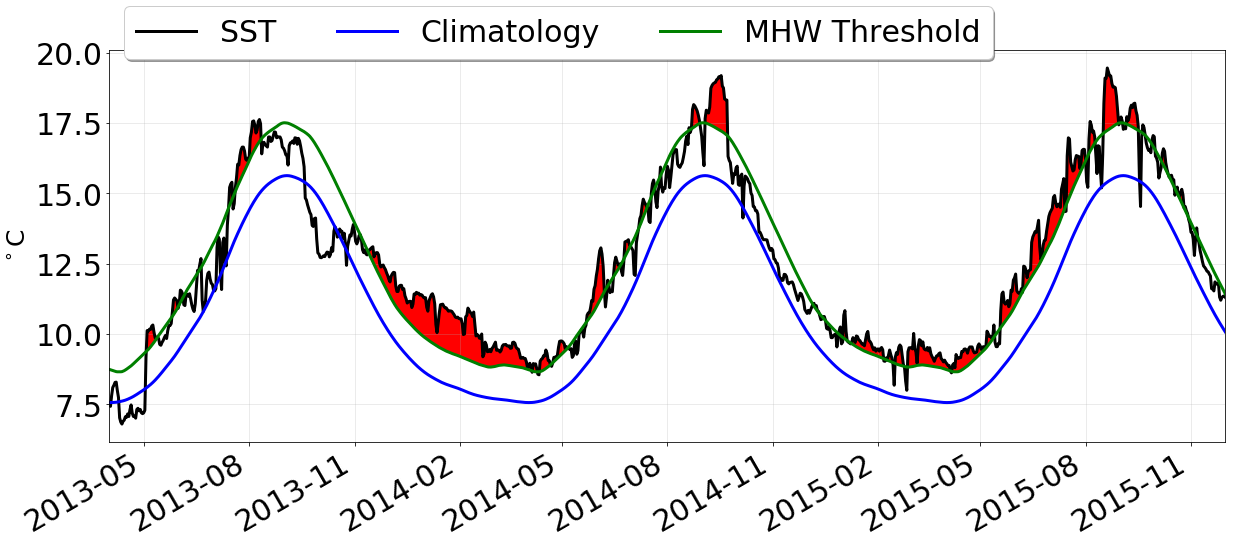

In [32]:
# Index in to time to get time slice between April-1-2013 and December-1-2015
T = len(time)
t_start= int(date(2013, 4, 1).toordinal())
t_end = int(date(2015, 12, 1).toordinal())
index_start = np.asscalar(np.where(time==t_start)[0])
index_end = np.asscalar(np.where(time == t_end)[0])
time_slice = np.arange(time[index_start],time[index_end+1])
dates = [date.fromordinal(tt.astype(int)) for tt in time_slice]

# Find a coordinate in the Pacific marine heatwave region (46ºN, 144ºW)
print(np.where(lat==46.125),np.where(lon==216.125))
print('latitude',lat[104],'ºN and longitude',180-(lon[364]-180),'ºW')
i = 104
j = 364

fig = plt.figure(figsize=(20, 8)) 
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
y1 = sst[index_start:index_end+1,i,j]
y2 = climatologoy_threshold[index_start:index_end+1,i,j]
plt.plot(dates, y1, dates, y2, color='k')
plt.fill_between(dates, y1, y2, where=y2 <= y1, facecolor='red', interpolate=True)
a= plt.plot(dates,np.squeeze(sst[index_start:index_end+1,i,j]),'k',label="SST",linewidth = 3)
b= plt.plot(dates,np.squeeze(seasonal_climatology[index_start:index_end+1,i,j]),'b',label="Climatology",linewidth = 3)
c= plt.plot(dates,np.squeeze(climatologoy_threshold[index_start:index_end+1,i,j]),'g',label="MHW Threshold",linewidth = 3)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1.15],ncol=3, shadow=True, fancybox=True,fontsize=30)
_=plt.ylabel('$^\circ$C',size=25)
plt.gcf().autofmt_xdate()
plt.grid(True,alpha = 0.3)
plt.xlim(dates[0], dates[-1])
ttl = plt.title('Defining Marine Heatwaves',fontname='Arial',fontsize=45,loc='center')

fig.savefig('definingMHW.png',bbox_inches='tight')

## Step #14. Plot SST Anomalies on February-01-2014

Saves as _Feb1_2014_SSTA.png_ in current working directory

***

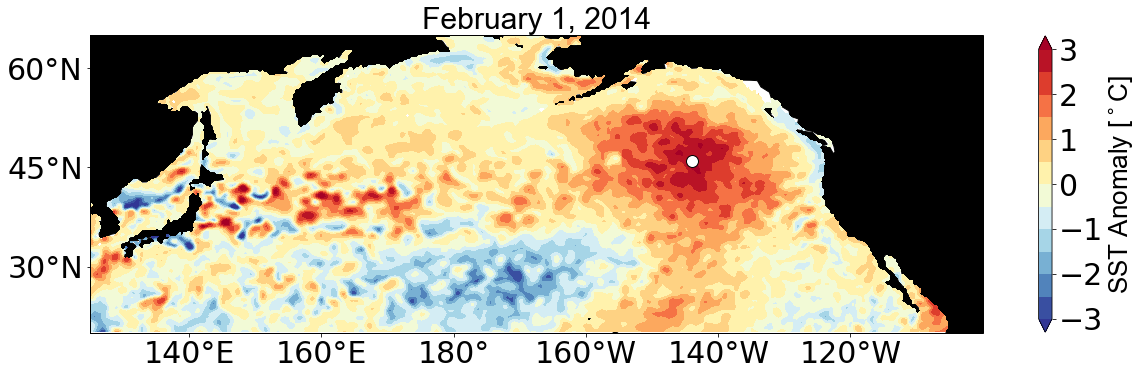

In [37]:
# Index time
t_val= int(date(2014,2, 1).toordinal())
t_ind = np.asscalar(np.where(time==t_val)[0])

fig = plt.figure(figsize=(20, 20)) # 8,10
# Label axes of a Plate Carree projection with a central longitude of 180:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_global()
ax1.set_extent([-55, 80, 20, 65], crs=ccrs.PlateCarree(central_longitude=180))
ax1.set_xticks([140,160,180,200,220,240], crs=ccrs.PlateCarree())
ax1.set_yticks([30,45,60], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
levels = [-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
CS = plt.contourf(lon-180, lat, np.squeeze(ssta[t_ind,:,:]), levels, cmap=plt.cm.RdYlBu_r,extend='both') 
cbar = plt.colorbar(CS, shrink=0.6, extend ='both')
ax1.add_feature(cfeature.LAND,facecolor='k')
ttl = plt.title('February 1, 2014',fontname='Arial',fontsize=30,loc='center')
cbar.ax.set_ylabel('SST Anomaly [$^\circ$C]',fontname='Arial',fontsize=26)

# plot marker to indicate location of timeseries in Step #13 figure 
plt.plot(216,46,color='white',markeredgecolor='black',linewidth=3,marker='o',markersize=12,transform=ccrs.Geodetic())

fig.savefig('Feb1_2014_SSTA.png',bbox_inches='tight')